**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [16]:
# imports for the project

import pandas as pd

## 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [17]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [18]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=1)
test_df = preprocess(test, frac=1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((120000, 2), (7600, 2))

## 2. Split the data

In [19]:
from sklearn.model_selection import train_test_split

(
    X_train,
    X_val,
    y_train,
    y_val
) = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(96000,) (24000,) (96000,) (24000,)


## 3. Build the BoW models
We will build the Bag-of-Words models with ´CountVectorizer´ and ´TfidfVectorizer´, with a baseline with default parameters and another with hyperparameter tuning. We will also use two different classifiers, logistic regression and random forest

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# count vectorizer with default parameters and hyperparameter tuning
cv_baseline = CountVectorizer()
cv_tuned = CountVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=1)

# tfidf vectorizer with default parameters and hyperparameter tuning
tv_baseline = TfidfVectorizer()
tv_tuned = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=1)

X_train_cv_baseline = cv_baseline.fit_transform(X_train)
X_train_cv_tuned = cv_tuned.fit_transform(X_train)
X_train_tv_baseline = tv_baseline.fit_transform(X_train)
X_train_tv_tuned = tv_tuned.fit_transform(X_train)

## 4. Create the classifiers
Implement the classifiers with default parameters and hyperparameter tuning. We will use logistic regression and random forest classifiers.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr_cv_baseline = LogisticRegression(max_iter=1000, n_jobs=-1) # Increase max_iter to avoid convergence warnings
lr_cv_tuned = LogisticRegression(C=1, max_iter=1000, n_jobs=-1)
lr_tv_baseline = LogisticRegression(max_iter=1000, n_jobs=-1) # Increase max_iter to avoid convergence warnings
lr_tv_tuned = LogisticRegression(C=1, max_iter=1000, n_jobs=-1)

# Random Forest
rf_cv_baseline = RandomForestClassifier(n_jobs=-1)
rf_cv_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_tv_baseline = RandomForestClassifier(n_jobs=-1)
rf_tv_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Fit models
lr_cv_baseline.fit(X_train_cv_baseline, y_train)
lr_cv_tuned.fit(X_train_cv_tuned, y_train)
lr_tv_baseline.fit(X_train_tv_baseline, y_train)
lr_tv_tuned.fit(X_train_tv_tuned, y_train)

rf_cv_baseline.fit(X_train_cv_baseline, y_train)
rf_cv_tuned.fit(X_train_cv_tuned, y_train)
rf_tv_baseline.fit(X_train_tv_baseline, y_train)
rf_tv_tuned.fit(X_train_tv_tuned, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

## 5. Get predictions

In [22]:
# Transform validation data using the fitted vectorizers
X_val_cv_baseline = cv_baseline.transform(X_val)
X_val_cv_tuned = cv_tuned.transform(X_val)
X_val_tv_baseline = tv_baseline.transform(X_val)
X_val_tv_tuned = tv_tuned.transform(X_val)

# Logistic Regression predictions
y_pred_lr_cv_baseline = lr_cv_baseline.predict(X_val_cv_baseline)
y_pred_lr_cv_tuned = lr_cv_tuned.predict(X_val_cv_tuned)
y_pred_lr_tv_baseline = lr_tv_baseline.predict(X_val_tv_baseline)
y_pred_lr_tv_tuned = lr_tv_tuned.predict(X_val_tv_tuned)

# Random Forest predictions
y_pred_rf_cv_baseline = rf_cv_baseline.predict(X_val_cv_baseline)
y_pred_rf_cv_tuned = rf_cv_tuned.predict(X_val_cv_tuned)
y_pred_rf_tv_baseline = rf_tv_baseline.predict(X_val_tv_baseline)
y_pred_rf_tv_tuned = rf_tv_tuned.predict(X_val_tv_tuned)

## 6. Evaluation

In [23]:
from sklearn.metrics import accuracy_score, classification_report

# Store accuracy for final comparison table
accuracy_summary = []

models = [
    ("LogReg + CountVec (baseline)", y_val, y_pred_lr_cv_baseline),
    ("LogReg + CountVec (tuned)", y_val, y_pred_lr_cv_tuned),
    ("LogReg + TfidfVec (baseline)", y_val, y_pred_lr_tv_baseline),
    ("LogReg + TfidfVec (tuned)", y_val, y_pred_lr_tv_tuned),
    ("RandForest + CountVec (baseline)", y_val, y_pred_rf_cv_baseline),
    ("RandForest + CountVec (tuned)", y_val, y_pred_rf_cv_tuned),
    ("RandForest + TfidfVec (baseline)", y_val, y_pred_rf_tv_baseline),
    ("RandForest + TfidfVec (tuned)", y_val, y_pred_rf_tv_tuned),
]

# Print classification report per model and collect accuracies
for name, y_true, y_pred in models:
    print(f"\n=== {name} ===")
    print("Performance on the validation set:")
    print(classification_report(y_true, y_pred, target_names=label_map.values()))

    acc = accuracy_score(y_true, y_pred)
    accuracy_summary.append((name, acc))

accuracy_df = pd.DataFrame(accuracy_summary, columns=["Model", "Accuracy"])
accuracy_df["Accuracy"] = accuracy_df["Accuracy"].round(3)
accuracy_df = accuracy_df.sort_values("Accuracy", ascending=False).reset_index(drop=True)

print("\n=== Accuracy Summary (sorted) ===")
display(accuracy_df)


=== LogReg + CountVec (baseline) ===
Performance on the validation set:
              precision    recall  f1-score   support

       World       0.87      0.87      0.87      6079
      Sports       0.88      0.88      0.88      6122
    Business       0.95      0.97      0.96      5878
    Sci/Tech       0.91      0.89      0.90      5921

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000


=== LogReg + CountVec (tuned) ===
Performance on the validation set:
              precision    recall  f1-score   support

       World       0.89      0.89      0.89      6079
      Sports       0.89      0.90      0.90      6122
    Business       0.95      0.98      0.97      5878
    Sci/Tech       0.93      0.90      0.92      5921

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.9

,Model,Accuracy
0,LogReg + CountVec (tuned),0.917
1,LogReg + TfidfVec (tuned),0.915
2,LogReg + TfidfVec (baseline),0.914
3,LogReg + CountVec (baseline),0.902
4,RandForest + TfidfVec (tuned),0.889
5,RandForest + CountVec (tuned),0.888
6,RandForest + CountVec (baseline),0.883
7,RandForest + TfidfVec (baseline),0.882


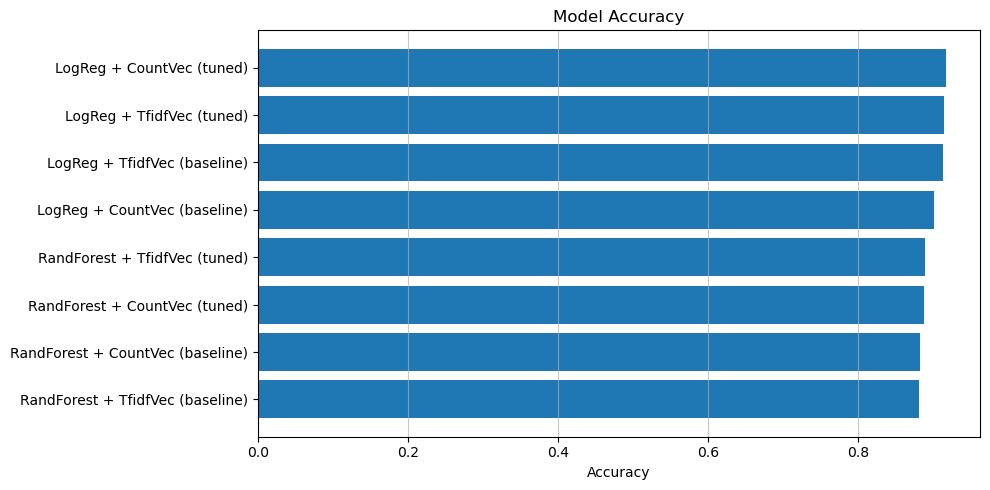

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(accuracy_df["Model"], accuracy_df["Accuracy"])
plt.xlabel("Accuracy")
plt.title("Model Accuracy")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='-', alpha=0.7)  # <-- Add this line
plt.tight_layout()
plt.show()

### Evaluate on the test set
We kinda forgot to evaluate the models on the test set, so we did this as the last thing during the analysis, apologies.

In [25]:
# Prepare test data
X_test_cv_baseline = cv_baseline.transform(test_df["text"])
X_test_cv_tuned = cv_tuned.transform(test_df["text"])
X_test_tv_baseline = tv_baseline.transform(test_df["text"])
X_test_tv_tuned = tv_tuned.transform(test_df["text"])
y_test = test_df["label"]

# Make predictions and collect accuracies
test_results = []

# Logistic Regression
test_results.append(("LogReg + CountVec (baseline)", accuracy_score(y_test, lr_cv_baseline.predict(X_test_cv_baseline))))
test_results.append(("LogReg + CountVec (tuned)", accuracy_score(y_test, lr_cv_tuned.predict(X_test_cv_tuned))))
test_results.append(("LogReg + TfidfVec (baseline)", accuracy_score(y_test, lr_tv_baseline.predict(X_test_tv_baseline))))
test_results.append(("LogReg + TfidfVec (tuned)", accuracy_score(y_test, lr_tv_tuned.predict(X_test_tv_tuned))))

# Random Forest
test_results.append(("RandForest + CountVec (baseline)", accuracy_score(y_test, rf_cv_baseline.predict(X_test_cv_baseline))))
test_results.append(("RandForest + CountVec (tuned)", accuracy_score(y_test, rf_cv_tuned.predict(X_test_cv_tuned))))
test_results.append(("RandForest + TfidfVec (baseline)", accuracy_score(y_test, rf_tv_baseline.predict(X_test_tv_baseline))))
test_results.append(("RandForest + TfidfVec (tuned)", accuracy_score(y_test, rf_tv_tuned.predict(X_test_tv_tuned))))

# Build and display results table
test_results_df = pd.DataFrame(test_results, columns=["Model", "Test Accuracy"])
test_results_df["Test Accuracy"] = test_results_df["Test Accuracy"].round(3)
test_results_df = test_results_df.sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

print("\n=== Test Set Accuracy ===")
display(test_results_df)


=== Test Set Accuracy ===


,Model,Test Accuracy
0,LogReg + CountVec (tuned),0.921
1,LogReg + TfidfVec (baseline),0.915
2,LogReg + TfidfVec (tuned),0.914
3,LogReg + CountVec (baseline),0.906
4,RandForest + TfidfVec (tuned),0.892
5,RandForest + CountVec (tuned),0.890
6,RandForest + CountVec (baseline),0.885
7,RandForest + TfidfVec (baseline),0.885


## 7. Reflections

The results (when using frac=1) were best using a tuned Logistic Regression model with CountVectorizer, achieving an accuracy of 0.921 with the test set. Notably, Logistic Regression consistently outperformed Random Forest across all models, likely due to the high dimensionality of BoW features which is something Random Forests tend to struggle with.
For the tuned models, the addition of bigrams and filtering out common words (max_df=0.9) improved performance, in particular for Log Reg ´CountVectorizer´. Perhaps there could be more utilisation of hyperparameter tuning, but considering its current state the performance is already quite good, with comparable results between test and validation sets, which suggests that the models are not overfitting.